In [18]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from helper import filter_spikes, compute_capacity, filter_spikes_parallel

# Global settings

In [2]:
T = 100  # total number of time steps (input values)
dt = 0.1  # simulation resolution

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,
    'print_time': True,
    'local_num_threads': 8})


Sep 04 23:17:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


# Input signal
We are going to drive the networks with a piece-wise constant input signal.

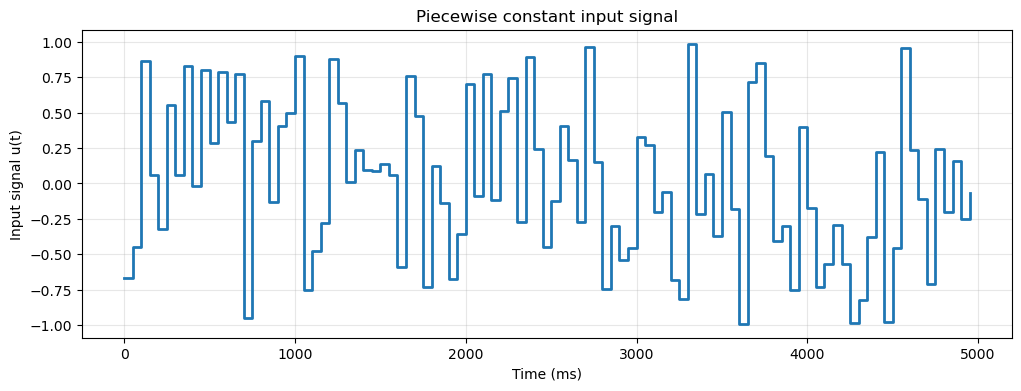

In [4]:
duration = 50.  # [ms] duration of each input step
u = np.random.uniform(-1, 1, T)  # input signal
input_times = np.arange(dt, T*duration, duration)  # time points when input changes

pl.figure(figsize=(12, 4))
pl.step(input_times, u, where='post', linewidth=2)
pl.xlabel('Time (ms)')
pl.ylabel('Input signal u(t)')
pl.title('Piecewise constant input signal')
pl.grid(True, alpha=0.3)
pl.show()

# Encoding layer
Create a population of neurons that encode the input signal with different tuning curves.

In [6]:
nEnc = 100  # number of encoding neurons
J_bias = 200.0  # [pA] - constant bias current

# Create encoding layer
enc_layer = nest.Create('iaf_psc_exp', nEnc, {'I_e': J_bias})
step_generator = nest.Create('step_current_generator', nEnc)

# Tuning curves for encoding layer
tuning = 250. * np.random.randn(nEnc) + 1000.

# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

amplitudes = np.zeros((nEnc, len(u)))
for n in range(nEnc):
    amplitudes[n, :] = u * tuning[n]
    
    # NEST 3 syntax: Use .set() method instead of nest.SetStatus()
    enc_layer[n].set({'V_m': Vm0[n], 'V_th': thresholds[n]})
    step_generator[n].set({'amplitude_times': input_times,
                          'amplitude_values': amplitudes[n]})
    
    # NEST 3 syntax: Connect individual nodes without list wrapping
    nest.Connect(step_generator[n], enc_layer[n])

In [9]:
enc_spks = nest.Create('spike_recorder')
nest.Connect(enc_layer, enc_spks)

# Recurrent network
Create a balanced excitatory-inhibitory network.

In [11]:
NE = 800  # number of excitatory neurons
NI = 200  # number of inhibitory neurons
N = NE + NI  # total number of neurons

CE = 80  # number of excitatory synapses per neuron
CI = CE // 4  # number of inhibitory synapses per neuron

w = 20.0  # excitatory synaptic weight [pA]
g = 5.0  # relative inhibitory to excitatory weight
d = 1.5  # synaptic delay [ms]

# Create neuron populations
neurons_e = nest.Create('iaf_psc_exp', NE)
neurons_i = nest.Create('iaf_psc_exp', NI)

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [12]:
# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

In [13]:
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

# Run simulation

In [14]:
# Run simulation with progress reporting
SimT = T * duration
print(f"Starting simulation for {SimT} ms...")

# Run simulation in chunks for progress reporting
chunk_size = 500.0  # ms
current_time = 0.0
while current_time < SimT:
    chunk = min(chunk_size, SimT - current_time)
    nest.Simulate(chunk)
    current_time += chunk
    progress = (current_time / SimT) * 100
    print(f"Progress: {progress:.1f}% ({current_time:.1f}/{SimT:.1f} ms)")
    sys.stdout.flush()

print("Simulation completed!")

Starting simulation for 5000.0 ms...

Sep 04 23:19:28 NodeManager::prepare_nodes [Info]: 
    Preparing 2932 nodes for simulation.
Progress: 10.0% (500.0/5000.0 ms)

Sep 04 23:19:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2932
    Simulation time (ms): 500
    Number of OpenMP threads: 8
    Not using MPI

[   3% ] Model time: 14.0 ms, Real-time factor: 0.2624Progress: 20.0% (1000.0/5000.0 ms)
[  64% ] Model time: 319.0 ms, Real-time factor: 0.2265eal-time factor: 0.2568Real-time factor: 0.2268

KeyboardInterrupt: 

[ 100% ] Model time: 500.0 ms, Real-time factor: 0.2097

Sep 04 23:19:28 SimulationManager::run [Info]: 
    Simulation finished.

Sep 04 23:19:28 NodeManager::prepare_nodes [Info]: 
    Preparing 2932 nodes for simulation.

Sep 04 23:19:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2932
    Simulation time (ms): 500
    Number of OpenMP threads: 8
    Not using MPI

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.17530.1784

Sep 04 23:19:28 SimulationManager::run [Info]: 
    Simulation finished.

Sep 04 23:19:28 NodeManager::prepare_nodes [Info]: 
    Preparing 2932 nodes for simulation.

Sep 04 23:19:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2932
    Simulation time (ms): 500
    Number of OpenMP threads: 8
    Not using MPI

[  30% ] Model time: 1150.0 ms, Real-time factor: 0.1731

# Analysis

In [20]:
filter_tau = 20. # [ms]

# NEST 3 syntax: Use .get() method instead of nest.GetStatus()
enc_activity = enc_spks.get('events')
enc_states = filter_spikes_parallel(enc_activity['times'], enc_activity['senders'], nEnc, 
                          t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau, n_processes=16)

e_activity = spikes_e.get('events')
e_states = filter_spikes_parallel(e_activity['times'], e_activity['senders'], NE, 
                        t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau, n_processes=16)

Filtering SpikeTrains: 100%|██████████| 800/800 [01:45<00:00,  7.55it/s]


# Visualization

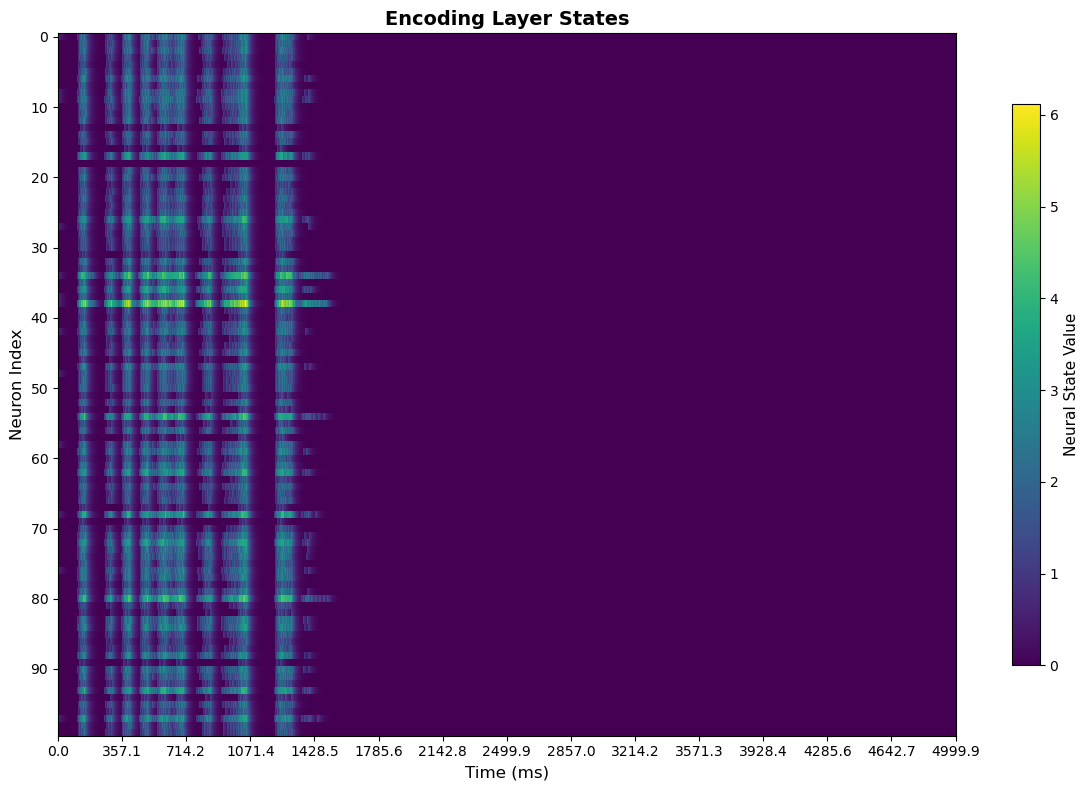

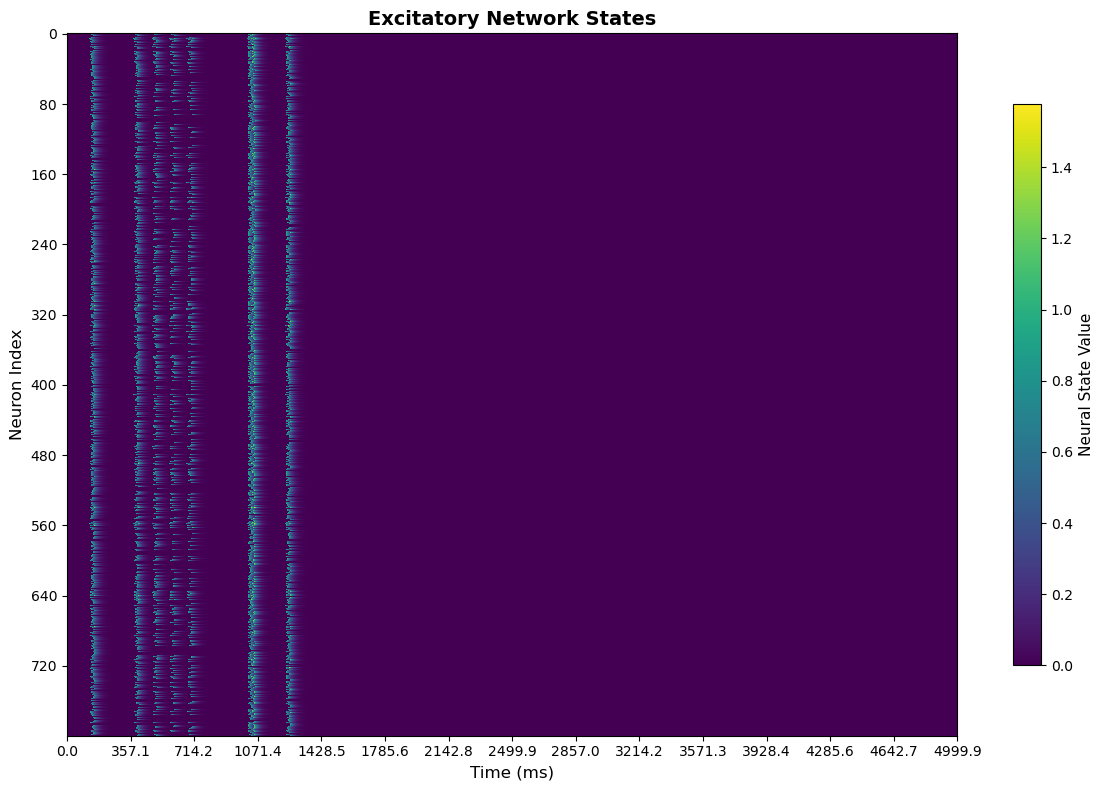

In [21]:
# Improved plotting function
def plot_neural_states(states, dt=0.1, title="Neural States Over Time"):
    """Create improved imshow plot with proper axis labels and time conversion"""
    fig, ax = pl.subplots(1, 1, figsize=(12, 8))
    
    # Create the imshow plot
    im = ax.imshow(states, aspect='auto', cmap='viridis', interpolation='nearest')
    
    # Get dimensions
    n_neurons, n_timesteps = states.shape
    
    # Convert x-axis ticks from steps to time (ms)
    n_ticks = min(15, n_timesteps // 10 + 1)
    tick_indices = np.linspace(0, n_timesteps - 1, n_ticks, dtype=int)
    tick_times = tick_indices * dt
    
    ax.set_xticks(tick_indices)
    ax.set_xticklabels([f'{t:.1f}' for t in tick_times])
    
    # Set y-axis ticks for neurons
    if n_neurons > 20:
        neuron_ticks = np.arange(0, n_neurons, max(1, n_neurons // 10))
    else:
        neuron_ticks = np.arange(0, n_neurons, max(1, n_neurons // 5))
    
    ax.set_yticks(neuron_ticks)
    ax.set_yticklabels([f'{int(n)}' for n in neuron_ticks])
    
    # Labels and title
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Neuron Index', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = pl.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Neural State Value', fontsize=11)
    
    pl.tight_layout()
    return fig, ax, im

# Plot encoding layer states
fig1, ax1, im1 = plot_neural_states(enc_states, dt=dt, title="Encoding Layer States")
pl.show()

# Plot excitatory network states
fig2, ax2, im2 = plot_neural_states(e_states, dt=dt, title="Excitatory Network States")
pl.show()

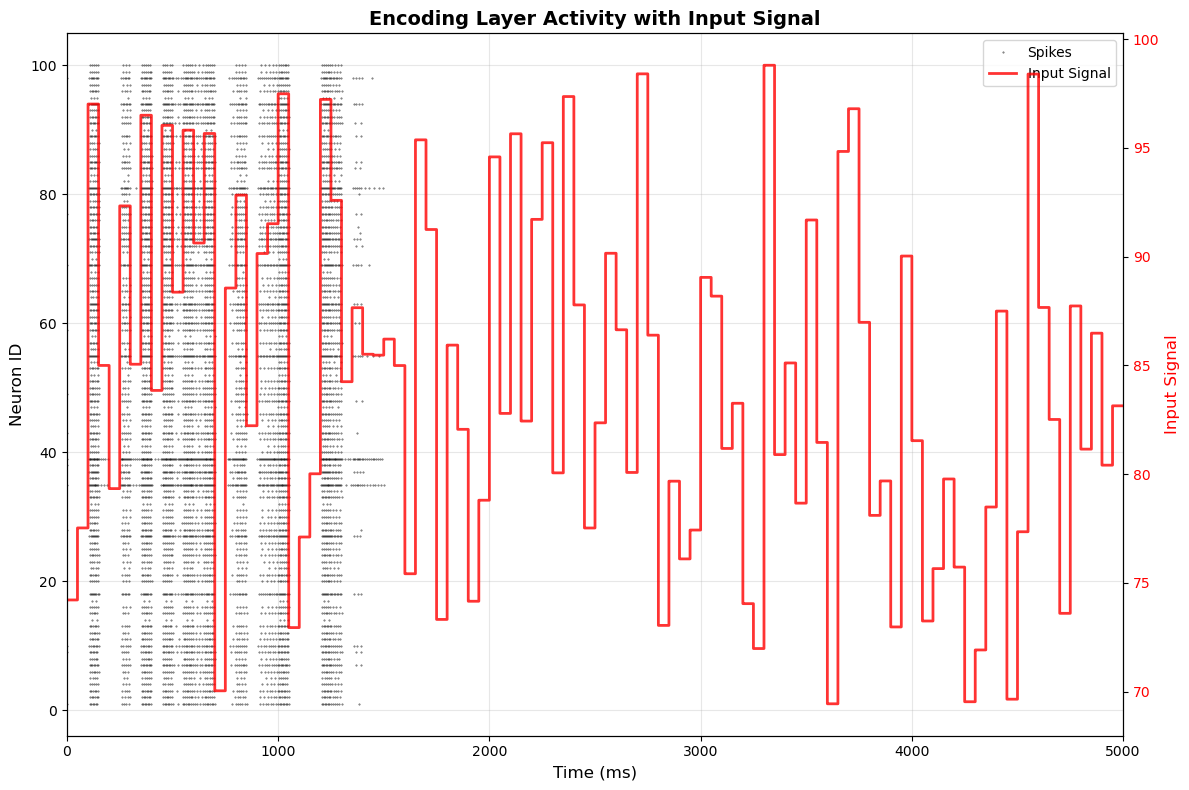

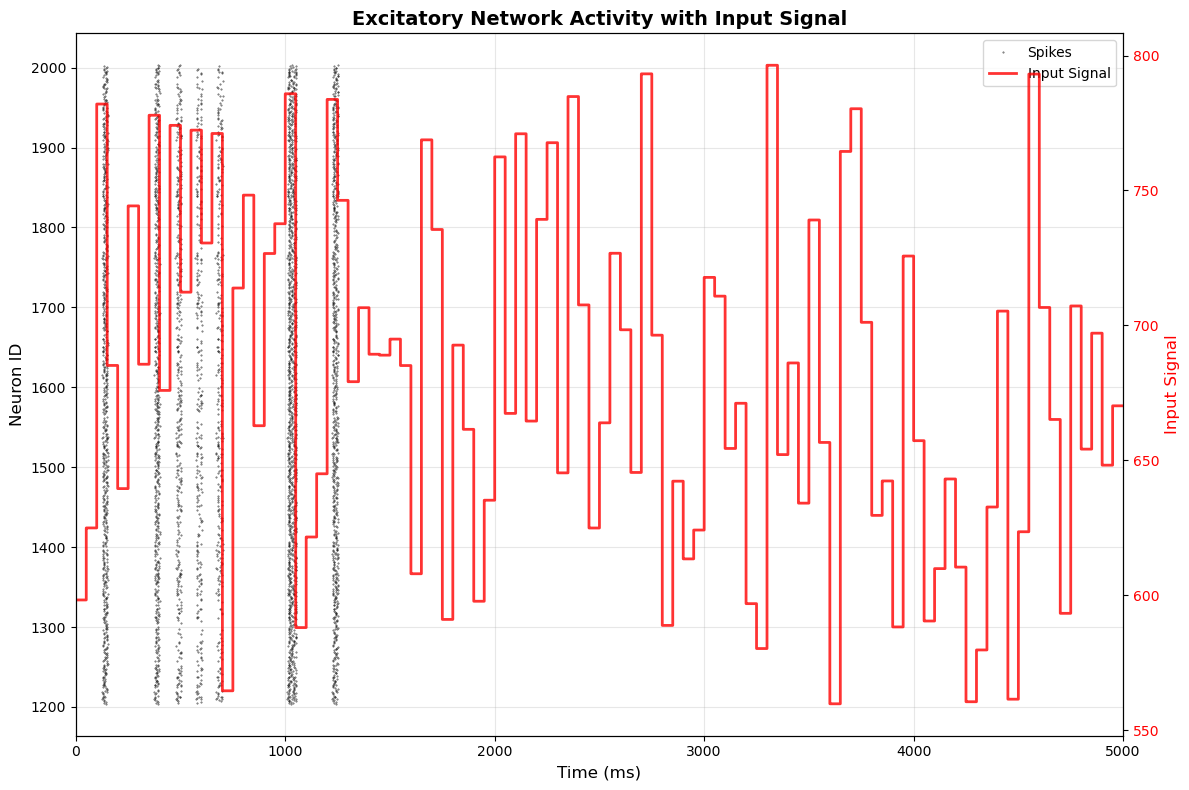

In [22]:
# Improved raster plot with signal overlay
def create_raster_with_signal(spike_times, neuron_ids, signal, time_vector, SimT, title="Neural Activity"):
    """Create single panel plot with signal overlaid on raster plot"""
    fig, ax = pl.subplots(1, 1, figsize=(12, 8))
    
    # Plot raster
    ax.plot(spike_times, neuron_ids, '.k', markersize=0.8, alpha=0.7, label='Spikes')
    
    # Set primary y-axis for neuron IDs
    ax.set_ylabel('Neuron ID', fontsize=12, color='black')
    ax.tick_params(axis='y', labelcolor='black')
    
    # Create secondary y-axis for signal
    ax2 = ax.twinx()
    
    # Scale signal to fit with neuron IDs
    N_neurons = len(np.unique(neuron_ids)) if len(neuron_ids) > 0 else 100
    signal_scaled = signal * (N_neurons * 0.15) + (N_neurons * 0.85)
    
    # Plot signal
    ax2.step(time_vector, signal_scaled, 'r-', linewidth=2, alpha=0.8, label='Input Signal', where='post')
    ax2.set_ylabel('Input Signal', fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Set tight x-limits
    x_min = 0
    x_max = SimT
    ax.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    
    # Labels and title
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Grid and legends
    ax.grid(True, alpha=0.3)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    pl.tight_layout()
    return fig, ax, ax2

# Create time vector for plotting
time_vector = np.arange(0, SimT, duration)
signal_extended = np.repeat(u, int(duration/dt))
time_vector_fine = np.arange(0, len(signal_extended)*dt, dt)

# Plot encoding layer activity
fig3, ax3, ax3_2 = create_raster_with_signal(enc_activity['times'], enc_activity['senders'], 
                                            signal_extended[:len(time_vector_fine)], 
                                            time_vector_fine, SimT, 
                                            "Encoding Layer Activity with Input Signal")
pl.show()

# Plot excitatory network activity
fig4, ax4, ax4_2 = create_raster_with_signal(e_activity['times'], e_activity['senders'], 
                                            signal_extended[:len(time_vector_fine)], 
                                            time_vector_fine, SimT, 
                                            "Excitatory Network Activity with Input Signal")
pl.show()

# Capacity Analysis

Computing memory capacity...

Elapsed time: 21.526437044143677 s
Lag 0: Capacity = 0.1533

Elapsed time: 21.258920431137085 s
Lag 1: Capacity = 0.1535

Elapsed time: 20.934083223342896 s
Lag 2: Capacity = 0.1537

Elapsed time: 30.74159049987793 s
Lag 3: Capacity = 0.1541

Elapsed time: 32.0016450881958 s
Lag 4: Capacity = 0.1542

Elapsed time: 26.187782049179077 s
Lag 5: Capacity = 0.1544

Elapsed time: 36.639172077178955 s
Lag 6: Capacity = 0.1547

Elapsed time: 26.87990379333496 s
Lag 7: Capacity = 0.1549

Elapsed time: 5.395468473434448 s
Lag 8: Capacity = 0.1552

Elapsed time: 21.119425535202026 s
Lag 9: Capacity = 0.1554

Elapsed time: 19.806185245513916 s
Lag 10: Capacity = 0.1557

Elapsed time: 18.929049253463745 s
Lag 11: Capacity = 0.1558

Elapsed time: 24.028423070907593 s
Lag 12: Capacity = 0.1560

Elapsed time: 7.6336212158203125 s
Lag 13: Capacity = 0.1561

Elapsed time: 9.083553552627563 s
Lag 14: Capacity = 0.1564

Elapsed time: 6.716880798339844 s
Lag 15: Capacity = 0.1

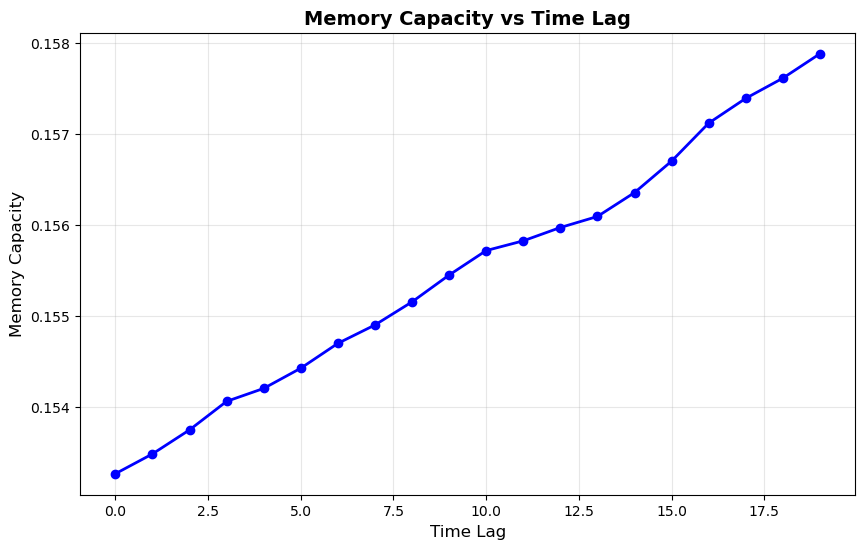


Total memory capacity: 3.1101
Zero-lag capacity: 0.1533


In [24]:
# Compute capacity for different time lags
print("Computing memory capacity...")

# Create target signal
signal_steps = len(e_states[0])
target_signal = np.repeat(u, signal_steps // len(u))
target_signal = target_signal[:signal_steps]  # Ensure same length

# Memory curve
max_lag = 20
capacities = []

for time_lag in range(max_lag):
    if time_lag == 0:
        target = target_signal
        states = e_states
    else:
        target = target_signal[:-time_lag]
        states = e_states[:, time_lag:]
    
    if len(target) > 0 and states.shape[1] > 0:
        _, c, error, norm = compute_capacity(states, target)
        capacities.append(c)
        print(f"Lag {time_lag}: Capacity = {c:.4f}")
    else:
        capacities.append(0.0)

# Plot memory capacity curve
pl.figure(figsize=(10, 6))
pl.plot(range(max_lag), capacities, 'bo-', linewidth=2, markersize=6)
pl.xlabel('Time Lag', fontsize=12)
pl.ylabel('Memory Capacity', fontsize=12)
pl.title('Memory Capacity vs Time Lag', fontsize=14, fontweight='bold')
pl.grid(True, alpha=0.3)
pl.show()

print(f"\nTotal memory capacity: {sum(capacities):.4f}")
print(f"Zero-lag capacity: {capacities[0]:.4f}")